# Politician Sentiment Analysis - Feature Selection

Name:       Devin Patel  
Class:      CS 588 - 01  
Term:       FA 22  
Project:    Determining party alignment based on 2016 Election tweets.  
File Purpose: To plot feature data and determine the best
              feature selection/dimensional reduction method.

## Initialization

In [77]:
# Imports
import numpy as np
import pandas as pd
import scipy.io
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest       # ANOVA
from sklearn.feature_selection import f_regression      # ANOVA
from sklearn.preprocessing import MinMaxScaler          # Normalizing data points


# Paths and Constants
twitter_data_path = r"Data/TweetData.pkl"
RANDOM_STATE = 12
KEPT_FEATURES = 2
NORM_RANGE = (0, 1)


In [78]:
# Exports pyplot figure
import os

def exportFig(fname):
    exportPath = "Figures/dimension_reduction"

    try:
        if not os.path.exists(exportPath): os.mkdir(exportPath)
    except Exception:
        print("Can't create a directory to store figures, so they will not be saved.")
        return
    
    exportPath = os.path.join(exportPath, fname)
    
    plt.savefig(exportPath)

In [79]:
# Loading Representative data from pkl file
X_df = pd.read_pickle(twitter_data_path, compression='infer')

# Separate ground truth from dataframe.
party_gth_df = pd.DataFrame(X_df.pop('Party'))

# Create class labels list for both ground truth dataframes
party_gth_labels = ["R", "D"] # Based on preprocessing: 0 = Republican, 1 = Democrat

# Create feature labels list
feature_labels = X_df.columns.values.tolist()

scaler_model = MinMaxScaler(feature_range=NORM_RANGE)
scaler_model.fit(X_df)
X = scaler_model.transform(X_df)
X_df = pd.DataFrame(X, columns=feature_labels)

# Data is ready
print(f"\nShape of main dataframe: {X_df.shape}")



Shape of main dataframe: (65952, 4)


## Correlation Matrix

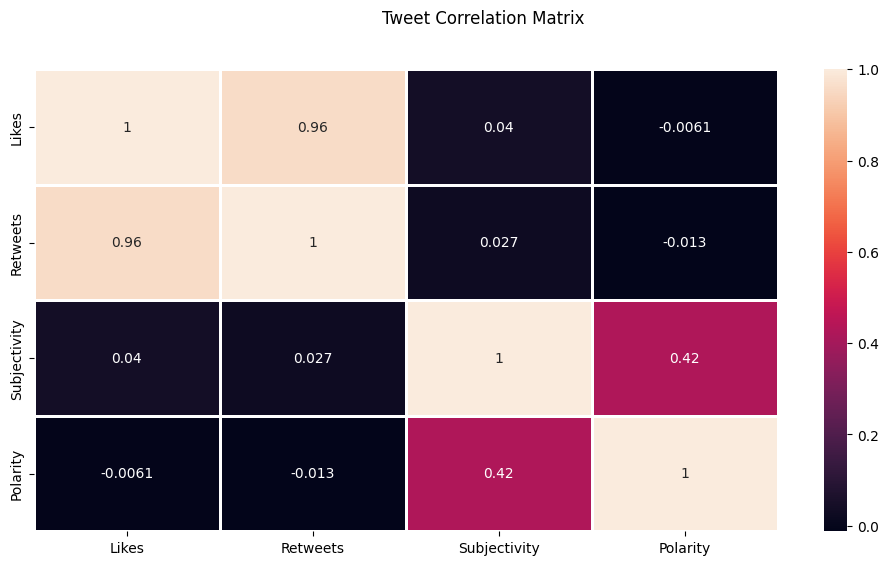

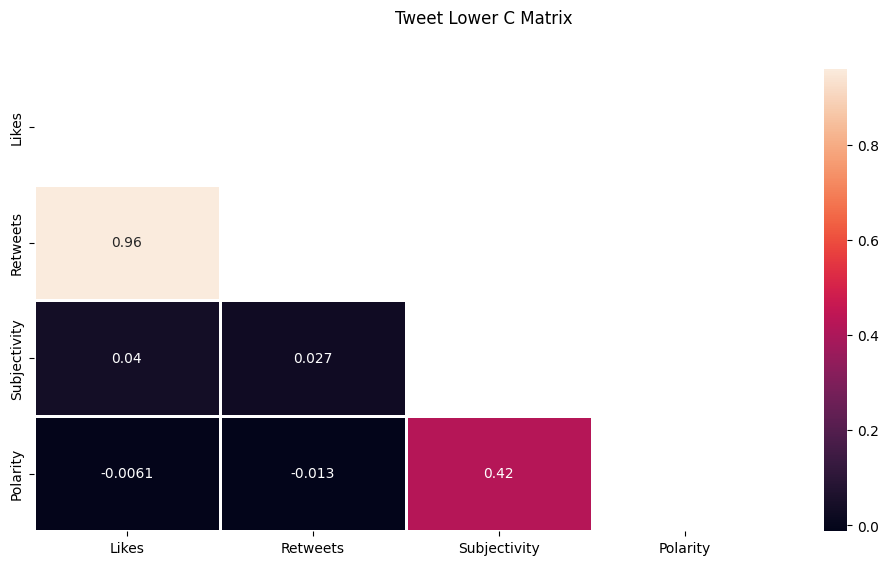

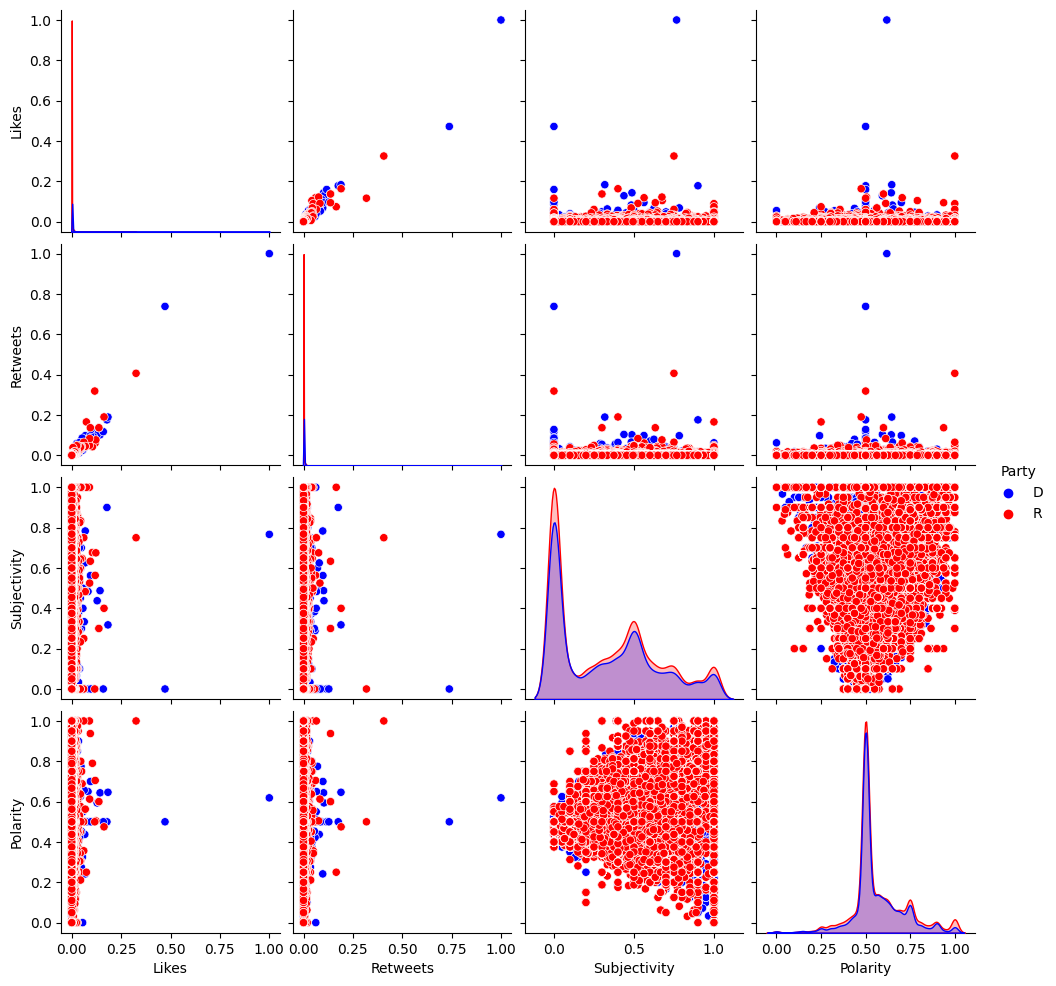

In [80]:
# @bookmark Correlation matrix
corr_eff = X_df.corr(numeric_only=True)

HEATSIZE = (12,6)
# Visualize iris features as heatmap
plt1 = plt.figure(figsize=HEATSIZE)
plt1.suptitle("Tweet Correlation Matrix")
sns.heatmap(corr_eff, linecolor='white', linewidths=1, annot=True)
exportFig(r"Correlation-Matrix.png")

# Visualize only lower triangular matrix
plt2_fig, plt2_ax = plt.subplots(figsize=HEATSIZE)
plt2_fig.suptitle("Tweet Lower C Matrix")

# Compute C matrix mask
mask = np.zeros_like(corr_eff)

# If mask = 0, display entire correlation matrix
# If mask = 1, display the unique lower triangular values
MASK_SETTING = 1
mask[np.triu_indices_from(mask)] = MASK_SETTING

# Creates heat map of plot 2
sns.heatmap(corr_eff, linecolor='white', linewidths=1, mask=mask, ax=plt2_ax, annot=True)

plt.show()

def toLabel(label):
    return party_gth_labels[label]

# Creates plots of classes by Party
g = sns.pairplot(pd.concat([X_df, party_gth_df['Party'].apply(toLabel)], axis=1), hue='Party', hue_order=party_gth_labels[::-1], palette={'R': '#FF0000', 'D': '#0000FF'})
exportFig(r"FullPlot-Party.png")
plt.show()


## PCA

In [81]:
# @bookmark PCA

# Run PCA on all features to get explained variance of all features
pca = PCA(n_components=len(feature_labels), random_state=RANDOM_STATE)
pca.fit_transform(X)

ev = list(pca.explained_variance_ratio_)
print(f"explained variance ratio: {ev}")


explained variance ratio: [0.8616564672926851, 0.1377416414154445, 0.0005897287876995042, 1.2162504170922773e-05]


Shape of X before PCA: (65952, 4)
New shape of X after PCA: (65952, 2)


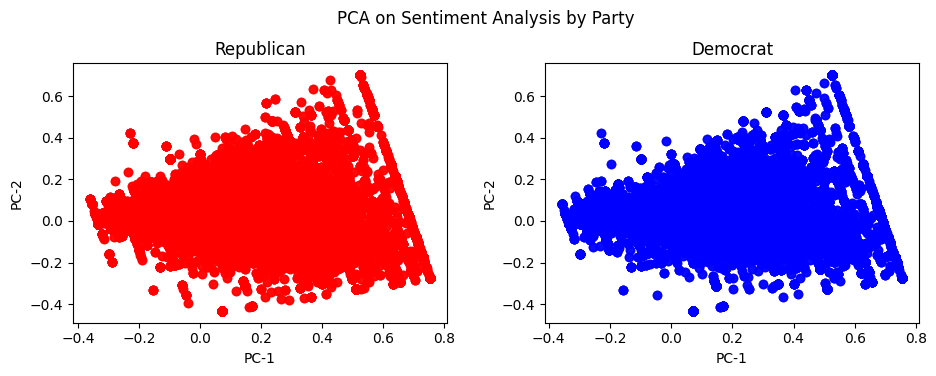

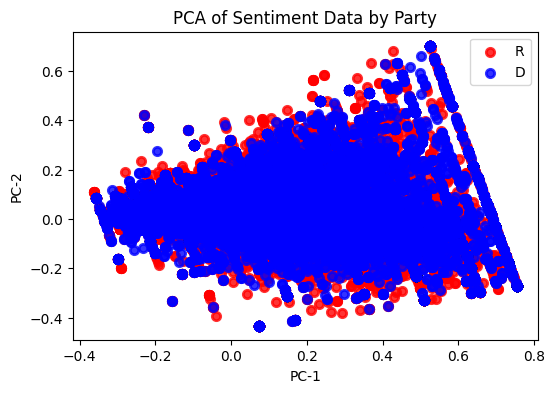

In [82]:
# PCA analysis
PCA_KEPT_COMPONENTS = KEPT_FEATURES # Max 4

pca = PCA(n_components=PCA_KEPT_COMPONENTS)
X_r = pca.fit_transform(X)
print(f"Shape of X before PCA: {X.shape}")
print(f"New shape of X after PCA: {X_r.shape}")

# Plot separate parties
def plot_separate_PCA_features(feature1, feature2, title="Default Title", outfile="outfile.png"):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    fig.tight_layout(pad=4.0)
    plt.suptitle(title)
    ax[0].set_title("Republican")
    ax[1].set_title("Democrat")
    ax[0].set_xlabel("PC-1")
    ax[0].set_ylabel("PC-2")
    ax[1].set_xlabel("PC-1")
    ax[1].set_ylabel("PC-2")
    party_colors = ['r', 'b']
    lw = 1

    for color, party, target_name in zip(party_colors, [i for i in range(len(party_gth_labels))], party_gth_labels):
        ax[0].scatter(X_r[party_gth_df['Party']==0, feature1], # X-axis
                    X_r[party_gth_df['Party']==0, feature2], # Y-axis
                    color=party_colors[0], alpha=.8, lw=lw, label=target_name)
        ax[1].scatter(X_r[party_gth_df['Party']==1, feature1], # X-axis
                    X_r[party_gth_df['Party']==1, feature2], # Y-axis
                    color=party_colors[1], alpha=.8, lw=lw, label=target_name)

    exportFig(outfile)

    plt.show()

# Plot two PC's with separate Party affiliation
plot_separate_PCA_features(0, 1, title="PCA on Sentiment Analysis by Party", outfile=r"PCA-separate.png")



# Plot two PC's overlayed with Party affiliation
plt.figure(figsize=(6,4))
plt.title("PCA of Sentiment Data by Party")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
party_colors = ['r', 'b']
lw = 2

for color, party, target_name in zip(party_colors, [i for i in range(len(party_gth_labels))], party_gth_labels):
    plt.scatter(X_r[party_gth_df['Party']==party,0], # X-axis
                  X_r[party_gth_df['Party']==party,1], # Y-axis
                  color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

exportFig(r"PCA-overlayed.png")
plt.show()


## LDA

In [83]:
# @bookmark LDA
LDA_KEPT_COMPONENTS = 1 # Max 1 because 2 parties
lda = LDA(n_components=LDA_KEPT_COMPONENTS)
X_r2 = lda.fit_transform(X, party_gth_df["Party"])

print(f"Shape of X before LDA: {X.shape}")
print(f"New shape of X after LDA: {X_r2.shape}")

print(X_r2)


Shape of X before LDA: (65952, 4)
New shape of X after LDA: (65952, 1)
[[ 0.03380225]
 [-0.1369298 ]
 [-0.86016077]
 ...
 [ 0.09721387]
 [ 0.08806428]
 [ 0.41905486]]


## ANOVA

In [84]:
# @bookmark ANOVA
ANOVA_KEPT_COMPONENTS = KEPT_FEATURES
fs = SelectKBest(score_func=f_regression, k=ANOVA_KEPT_COMPONENTS)
X_r3 = fs.fit_transform(X, party_gth_df['Party'])


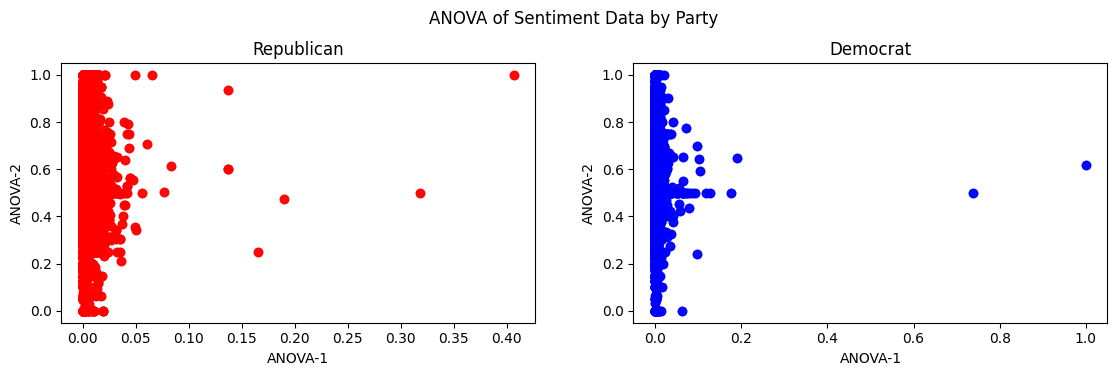

In [85]:
# Plot ANOVA
def plot_separate_ANOVA_features(feature1, feature2, title="Default Title", outfile="outfile.png"):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    fig.tight_layout(pad=4.0)
    plt.suptitle(title)
    ax[0].set_title("Republican")
    ax[1].set_title("Democrat")
    ax[0].set_xlabel("ANOVA-1")
    ax[0].set_ylabel("ANOVA-2")
    ax[1].set_xlabel("ANOVA-1")
    ax[1].set_ylabel("ANOVA-2")
    party_colors = ['r', 'b']
    lw = 1

    for color, party, target_name in zip(party_colors, [i for i in range(len(party_gth_labels))], party_gth_labels):
        ax[0].scatter(X_r3[party_gth_df['Party']==0, feature1], # X-axis
                    X_r3[party_gth_df['Party']==0, feature2], # Y-axis
                    color=party_colors[0], alpha=.8, lw=lw, label=target_name)
        ax[1].scatter(X_r3[party_gth_df['Party']==1, feature1], # X-axis
                    X_r3[party_gth_df['Party']==1, feature2], # Y-axis
                    color=party_colors[1], alpha=.8, lw=lw, label=target_name)

    exportFig(outfile)

    plt.show()
    
plot_separate_ANOVA_features(feature1=0, feature2=1, title="ANOVA of Sentiment Data by Party", outfile="ANOVA-Party.png")
